In [3]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

In [4]:
# Reading the data file into a DATAFRAME and checking the shape 
data=pd.read_csv('reviews.csv')
print(data.shape)

(71922, 2)


In [5]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text
    
    

stop=set(stopwords.words('english'))
print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)


s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'CleanReviews.csv')

{'ll', 'these', 'because', 'few', 'nor', 'am', 'so', "you'll", 'do', 'each', 'if', "you'd", 'below', 'mustn', 'haven', 'until', 'some', 'any', 't', "hadn't", 'this', "you've", 'was', 'ourselves', 'don', "wasn't", 'themselves', 'whom', 'herself', 'from', 'does', 'being', "mightn't", "wouldn't", "weren't", 'him', 'than', 'should', 'o', 'theirs', 'once', 'under', 'hasn', 'himself', 'on', 'very', 'doesn', 'its', 'wouldn', 'while', 'just', 'a', 'where', "shan't", 'y', 'for', 'those', 'aren', 'but', 'your', 'most', 'has', 're', "she's", 've', 'up', 'no', 'her', 'same', "doesn't", 'didn', "couldn't", 'out', 'down', 'itself', 'there', 'we', 'again', 'weren', 'm', "should've", 'with', 'have', 'all', 'his', 'about', "you're", 'their', 'of', 'been', "won't", "needn't", 'yours', "that'll", 'isn', 'it', 'ma', "didn't", 'having', 'they', 'you', "shouldn't", 'by', 'not', 'here', 'when', 'against', 'my', 'is', 'he', 'that', 'too', 's', 'shan', 'or', 'who', 'wasn', 'own', 'yourself', 'through', 'needn'

In [6]:
data=pd.read_csv('CleanReviews.csv')
print(data.shape)
label = data['decision'].values
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(71922, 5)
(71922,)
(71922, 4)
------------------------------
(57537, 4)
(14385, 4)
(57537,)
(14385,)


In [7]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

After vectorizations
(57537, 30701)
(14385, 30701)
(57537,)
(14385,)
...............................


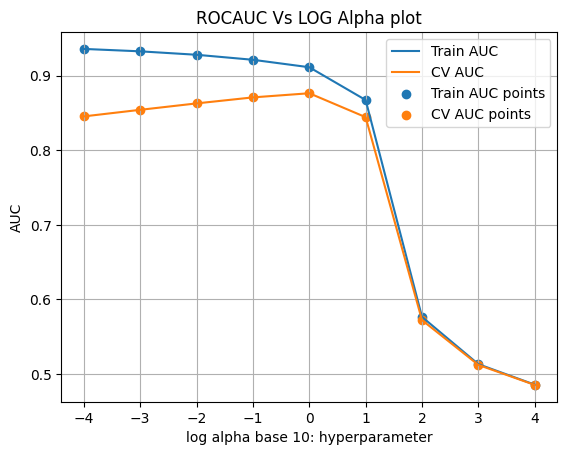

{'alpha': 1.0}
0.8762956063903633
best alpha log value
0.0


In [8]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt

l=[0.5,0.5]# Taking equal prior probability values

neigh = MultinomialNB(fit_prior='false',class_prior=l)#Taking Model Multinomial Naive Bayes


alphas=np.array([0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different alpha values
tuned_parameters = {'alpha' : alphas} # alpha values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_alpha']

# alpha value is taken as log alpha value
alpha1=[]
for i in range(0,len(k),1):
   l=math.log10(k[i])
   alpha1.append(l)
alpha1.sort()
#print(alpha1)

plt.plot(alpha1, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(alpha1, cv_auc, label='CV AUC')



plt.scatter(alpha1, train_auc, label='Train AUC points')
plt.scatter(alpha1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha base 10: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)
print("best alpha log value")
a=math.log10(clf.best_params_.get('alpha'))
print(a)



